Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:25<00:00, 392844.11it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 121983.97it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 845804.20it/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Epoch [1/50], Step [100/469], D Loss: 0.1183, G Loss: 2.3393
Epoch [1/50], Step [200/469], D Loss: 1.4637, G Loss: 0.7073
Epoch [1/50], Step [300/469], D Loss: 1.0017, G Loss: 1.7077
Epoch [1/50], Step [400/469], D Loss: 1.5269, G Loss: 0.4285
Epoch [2/50], Step [100/469], D Loss: 0.4874, G Loss: 2.9120
Epoch [2/50], Step [200/469], D Loss: 0.2871, G Loss: 4.1965
Epoch [2/50], Step [300/469], D Loss: 0.3035, G Loss: 4.1238
Epoch [2/50], Step [400/469], D Loss: 0.3835, G Loss: 2.1594
Epoch [3/50], Step [100/469], D Loss: 0.8459, G Loss: 3.6807
Epoch [3/50], Step [200/469], D Loss: 0.1750, G Loss: 5.9873
Epoch [3/50], Step [300/469], D Loss: 0.0784, G Loss: 6.2987
Epoch [3/50], Step [400/469], D Loss: 0.3898, G Loss: 10.2564
Epoch [4/50], Step [100/469], D Loss: 0.1541, G Loss: 2.9409
Epoch [4/50], Step [200/469], D Loss: 2.1091, G Loss: 3.8758
Epoch [4/50], Step [300/469], D Loss: 0.1747, G Loss: 3.9762
Epoch [4/

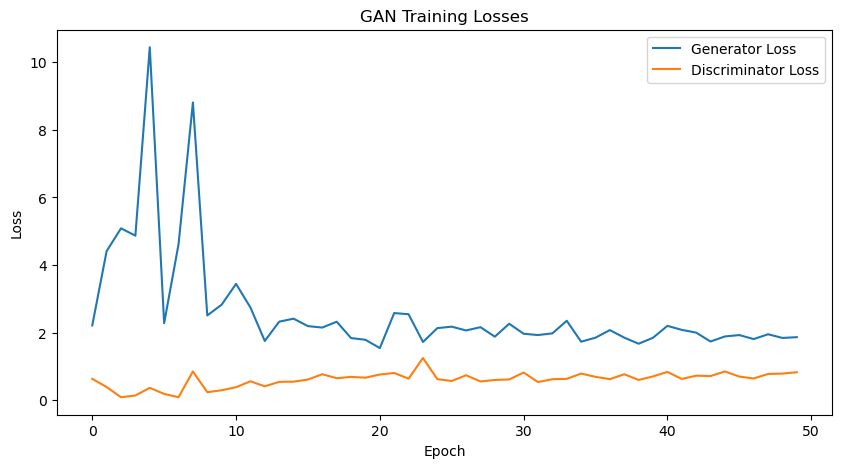

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


latent_dim = 100  
epochs = 50  
batch_size = 128 
learning_rate = 0.0002  


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 28*28)
        self.tanh = nn.Tanh()

    def forward(self, z):
        x = torch.relu(self.fc1(z))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return self.tanh(x).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 28*28)  
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return self.sigmoid(x)


generator = Generator().to(device)
discriminator = Discriminator().to(device)


criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


def train_gan():
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    total_steps = len(train_loader)


    g_losses, d_losses = [], []

    for epoch in range(epochs):
        for i, (images, _) in enumerate(train_loader):
            images = images.to(device)


            optimizer_d.zero_grad()

            
            outputs = discriminator(images)
            d_loss_real = criterion(outputs, real_labels[:images.size(0)])
            d_loss_real.backward()

            
            z = torch.randn(images.size(0), latent_dim).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels[:images.size(0)])
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake
            optimizer_d.step()

            
            optimizer_g.zero_grad()

            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels[:images.size(0)])
            g_loss.backward()
            optimizer_g.step()

            
            if (i+1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{total_steps}], "
                      f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

        
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        
        if (epoch + 1) % 10 == 0:
            save_generated_images(epoch + 1)

    return g_losses, d_losses


def save_generated_images(epoch):
    z = torch.randn(64, latent_dim).to(device)
    fake_images = generator(z)
    fake_images = fake_images.cpu().detach()
    grid = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f'Epoch {epoch}')
    plt.axis('off')
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()


g_losses, d_losses = train_gan()


plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Training Losses')
plt.show()
